In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [29]:
def center_crop_and_pad(image, size):
    """
    Center crop or pad the given image to the desired size.

    Args:
        image (numpy.ndarray): Input image to resize.
        size (int): Desired size (p x p).

    Returns:
        numpy.ndarray: Resized image of shape (size, size).
    """
    # print("img shape : ", image.shape)
    h, w = image.shape[:2]

    p = size

    if h > p or w > p:
        # Center crop
        start_x = max((w - p) // 2, 0)
        start_y = max((h - p) // 2, 0)
        end_x = start_x + p
        end_y = start_y + p

        cropped_image = image[start_y:end_y, start_x:end_x]
    else:
        cropped_image = image

    # Pad with zeros
    padded_image = np.zeros((p, p), dtype=image.dtype)
    offset_x = (p - cropped_image.shape[1]) // 2
    offset_y = (p - cropped_image.shape[0]) // 2
    padded_image[offset_y:offset_y + cropped_image.shape[0], offset_x:offset_x + cropped_image.shape[1]] = cropped_image

    return padded_image

[[255 255 255 255 255]
 [255   0   0   0 255]
 [255   0   0   0 255]
 [255   0   0   0 255]
 [255 255 255 255 255]]


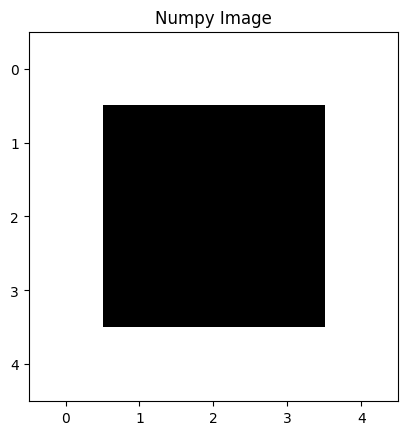

[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0 255 255 255 255 255   0   0   0]
 [  0   0 255   0   0   0 255   0   0   0]
 [  0   0 255   0   0   0 255   0   0   0]
 [  0   0 255   0   0   0 255   0   0   0]
 [  0   0 255 255 255 255 255   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]]


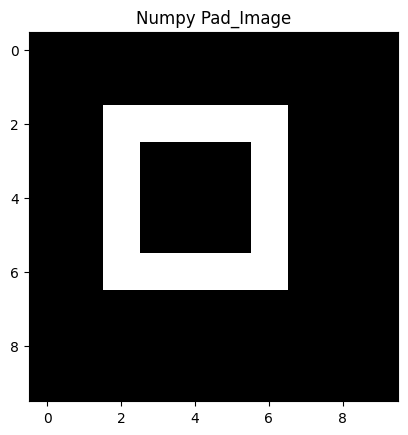

In [30]:
# unit test for center_crop_and_pad()
# Create a numpy image of dimension 5h and 10w
image = np.zeros((5, 5), dtype=np.uint8)
# image[2, 5] = 255
# image[0, 0] = 255
# image[4, 2] = 255

# Add 255 to all the edges of the image
image[0, :] = 255
image[-1, :] = 255
image[:, 0] = 255
image[:, -1] = 255
print(image)
plt.imshow(image, cmap='gray')
plt.title('Numpy Image')
plt.show()
pad_image = center_crop_and_pad(image, 10)
print(pad_image)
plt.imshow(pad_image, cmap='gray')
plt.title('Numpy Pad_Image')
plt.show()

In [31]:
def extract_connected_components(I, IGF, fixed_size=18, height_range=(3, 90), width_range=(2, 100)):
    """
    Extracts strongly connected components from an image and its guided filtered version.

    Args:
        I (numpy.ndarray): Original grayscale image.
        IGF (numpy.ndarray): Guided filtered version of the original image.
        fixed_size (int): The size to which each extracted letter image is resized (default: 32x32).
        height_range (tuple): Min and max height of components to consider.
        width_range (tuple): Min and max width of components to consider.

    Returns:
        list: List of two-channel images (numpy arrays) for each connected component.
    """
    # Step 1: Threshold the original grayscale image to obtain a binary image
    _, binary = cv2.threshold(I, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Step 2: Apply connected component analysis
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary, connectivity=8)

    # Step 3: Filter out components based on area and size
    areas = stats[:, cv2.CC_STAT_AREA]
    median_area = np.median(areas)

    filtered_components = []
    for i in range(1, num_labels):  # Skip the background component (label 0)
        x, y, w, h, area = stats[i, cv2.CC_STAT_LEFT], stats[i, cv2.CC_STAT_TOP], stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT], stats[i, cv2.CC_STAT_AREA]
        
        if (0.5 * median_area <= area <= 4 * median_area and
            height_range[0] <= h <= height_range[1] and
            width_range[0] <= w <= width_range[1]):
            filtered_components.append(i)

    # Step 4: Extract and preprocess connected components from both images
    two_channel_images = []
    for comp_id in filtered_components:
        x, y, w, h = stats[comp_id, cv2.CC_STAT_LEFT], stats[comp_id, cv2.CC_STAT_TOP], stats[comp_id, cv2.CC_STAT_WIDTH], stats[comp_id, cv2.CC_STAT_HEIGHT]

        # Extract bounding boxes from both original and guided filtered images
        letter_I = I[y:y+h, x:x+w]
        letter_IGF = IGF[y:y+h, x:x+w]

        # Resize the extracted letters to a fixed size. centre crop for larger images
        # and pad for smaller images
        resized_I = center_crop_and_pad(letter_I, fixed_size)
        resized_IGF = center_crop_and_pad(letter_IGF, fixed_size)

        # Stack as two channels
        combined_image = np.stack([resized_I, resized_IGF], axis=-1)
        two_channel_images.append(combined_image)

    return two_channel_images

In [32]:
import os
import cv2
import numpy as np

def get_image_files(folder):
    """
    Get sorted list of valid image files in a folder.
    
    Args:
        folder (str): Path to the folder.
        
    Returns:
        list: Sorted list of image file names.
    """
    valid_extensions = {".png", ".jpg", ".jpeg", ".bmp", ".tiff"}  # Add more if needed
    files = [
        f for f in os.listdir(folder)
        if os.path.isfile(os.path.join(folder, f)) and os.path.splitext(f.lower())[1] in valid_extensions
    ]
    return sorted(files)

In [33]:


def process_images(wa_images, guided_images, fixed_size=18, height_range=(3, 90), width_range=(2, 100)):
    """
    Process paired images from two folders.

    Args:
        wa_images (str): Path to the folder with original grayscale images.
        guided_images (str): Path to the folder with guided filtered images.
        fixed_size (int): The size to which each extracted component is resized.
        height_range (tuple): Min and max height of components to consider.
        width_range (tuple): Min and max width of components to consider.

    Returns:
        dict: Dictionary with file names as keys and lists of extracted components as values.
    """
    results = {}
    
    # Get sorted lists of valid image files from both folders
    files1 = get_image_files(wa_images)
    files2 = get_image_files(guided_images)
    
    for file1, file2 in zip(files1, files2):
        # Ensure the file names match
        if file1 == file2:
            path1 = os.path.join(wa_images, file1)
            path2 = os.path.join(guided_images, file2)
            
            # Read images
            I = cv2.imread(path1, cv2.IMREAD_GRAYSCALE)
            IGF = cv2.imread(path2, cv2.IMREAD_GRAYSCALE)

            if I is None or IGF is None:
                print(f"Error loading images: {file1}, {file2}")
                continue

            # Extract connected components
            components = extract_connected_components(I, IGF, fixed_size, height_range, width_range)
            results[file1] = components
        else:
            print(f"File mismatch: {file1} and {file2}")

    # print("resutls.items() : ", results.items())
    return results



In [34]:
def save_separate_results_as_images(results, output_folder):
    """
    Save processed results as grayscale .png images in separate folders for original and guided images.

    Args:
        results (dict): Dictionary with file names as keys and lists of components as values.
        output_folder (str): Path to the main output folder where results will be saved.
    """
    

    for filename, components in results.items():
        doc_name = os.path.splitext(filename)[0]  # Get the doc name without extension

        # Create subfolders for this image
        doc_folder = os.path.join(output_folder, doc_name)
        original_subfolder = os.path.join(doc_folder, "original")
        guided_subfolder = os.path.join(doc_folder, "guided")
        os.makedirs(original_subfolder, exist_ok=True)
        os.makedirs(guided_subfolder, exist_ok=True)

        for i, component in enumerate(components):
            # Separate the two channels
            original_channel = (component[:, :, 0]).astype(np.uint8)  # First channel
            guided_channel = (component[:, :, 1]).astype(np.uint8)  # Second channel

            # Save each channel in its respective folder
            path_original = os.path.join(original_subfolder, f"component_{i + 1}.png")
            path_guided = os.path.join(guided_subfolder, f"component_{i + 1}.png")

            cv2.imwrite(path_original, original_channel)
            cv2.imwrite(path_guided, guided_channel)

            print(f"Saved: {path_original}")
            print(f"Saved: {path_guided}")


In [ ]:

wa_images_grayscale = "WA_images_grayscale"  # Path to folder with original images
guided_images = "guided_images"  # Path to folder with guided images
output_folder = "letter_components"  # Main output folder

processed_results = process_images(wa_images_grayscale, guided_images, fixed_size=18, height_range=(3, 90), width_range=(2, 100))
save_separate_results_as_images(processed_results, output_folder)
print(f"Processed and saved results for {len(processed_results)} image pairs.")
